<a href="https://colab.research.google.com/github/vyankateshgithubber/Audio-Source-Count-Estimation/blob/working/FinalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import Libraries 
import librosa
import numpy as np
import matplotlib.pyplot as plt
!pip install wavefile
import wavefile
import wave, os, glob
from matplotlib.pyplot import figure
import math
from scipy.io.wavfile import write

  Created wheel for wavefile: filename=wavefile-1.5-py3-none-any.whl size=11587 sha256=23277341a353ffac674297d901d2b42dc5e02c313ad90de7e499b9bce9cf1ab9
  Stored in directory: /root/.cache/pip/wheels/da/13/0f/4cef0631e2b18df2da6ebad4065f076b1807af1aecd1dce1a0
Successfully built wavefile


In [3]:
####ADDED FROM GAURAV VYAS , TRIMMED STFT
def freq_thresh_index(fs,n_fft,thresh=4000):
  x=librosa.fft_frequencies(fs, n_fft=512)
  print(x.shape)
  for i in range(len(x)):
    if(x[i]>thresh):
      N=i-1
      break
  print(N)
  print(x[N],"frequency above this will be removed")
  return N
n=freq_thresh_index(fs=16000,n_fft=512,thresh=4000)

(257,)
128
4000.0 frequency above this will be removed


In [10]:
#ADDED FROM GAURAV VYAS , TRIMMED STFT
def stft(y,sr):
  S = abs(librosa.stft(y,n_fft=512,hop_length=256))
  #print(n)
  R1= np.array(S)
  r = R1[0:n+1, :]
  return r

In [5]:
####code that will give the offset value for 1s audio file which has the maximum energy, no framing and windowing was done . 
# directly 16K samples for 1s are taken and the energy is caluculated and they are ranked accordingly.
def GiveMeOffset(filename):
  signal, sr = librosa.load(filename,sr=16000)
  requiredOffset=0
  Max=0
  count=0
  for i in range(0,sr*5,sr):
    frameOfOneSecond=signal[i:i+16000]
    energy = np.array(sum(abs(frameOfOneSecond**2)))
    #print(energy)
    if energy>Max:
      requiredOffset=i//sr
      Max=energy
  return requiredOffset

In [6]:
## Mix Libricount and custom dataset
def features_labels(sr=16000,offset=0,duration=1):
  X = []
  y = []

  path = '/content/drive/MyDrive/MajorProject/AudioDataset/45_165/'

  for k1 in np.arange(0.02,1.02,0.02):
    for k2 in np.arange(0.02,1.02,0.02):
      audiofilepath = path+'2_'+str(round(k1,3))+'_'+str(round(k2,3))+'.wav'
      offset = GiveMeOffset(audiofilepath)
      signal, sr = librosa.load(audiofilepath,sr=sr,offset=offset,duration=duration)
      X.append(stft(signal,sr))
      y.append(2)

  for k1 in np.arange(0.001,1.001,0.001):
    audiofilepath = path+'1_'+str(round(k1,3))+'_'+str(round(0,3))+'.wav'
    offset = GiveMeOffset(audiofilepath)
    signal, sr = librosa.load(audiofilepath,sr=sr,offset=offset,duration=duration)
    X.append(stft(signal,sr))
    y.append(1)


  for k1 in np.arange(0.001,1.001,0.001):
    audiofilepath = path +'1_'+str(round(0,3))+'_'+str(round(k1,3))+'.wav'
    offset = GiveMeOffset(audiofilepath)
    signal, sr = librosa.load(audiofilepath,sr=sr,offset=offset,duration=duration)
    X.append(stft(signal,sr))
    y.append(1)

  
  path = '/content/drive/MyDrive/MajorProject/AudioDataset/New folder'
  for filename in glob.glob(os.path.join(path, '2'+'*.wav')):
    offset = GiveMeOffset(filename)
    signal, sr = librosa.load(filename,sr=sr,offset=offset,duration=duration)
    X.append(stft(signal,sr))
    y.append(2)


  for filename in glob.glob(os.path.join(path, '1'+'*.wav')):
    offset = GiveMeOffset(filename)
    signal, sr = librosa.load(filename,sr=sr,offset=offset,duration=duration)
    X.append(stft(signal,sr))
    y.append(1)  

  for filename in glob.glob(os.path.join(path, '3'+'*.wav')):
    offset = GiveMeOffset(filename)
    signal, sr = librosa.load(filename,sr=sr,offset=offset,duration=duration)
    X.append(stft(signal,sr))
    y.append(3)
  

  for filename in glob.glob(os.path.join(path, '4'+'*.wav')):
    offset = GiveMeOffset(filename)
    signal, sr = librosa.load(filename,sr=sr,offset=offset,duration=duration)
    X.append(stft(signal,sr))
    y.append(3)


  #add the code so as to take the audio file and append the x and y lablel for the 0 source,
  #source 0-0 , source 1-1 and source 2-2 (sources,labels)
  path = '/content/drive/MyDrive/MajorProject/AudioDataset/0'
  for filename in glob.glob(os.path.join(path, '*.wav')):
    offset = GiveMeOffset(filename)
    signal, sr = librosa.load(filename,sr=sr,offset=offset,duration=duration)
    X.append(stft(signal,sr))
    y.append(0)


  X = np.array(X)
  y = np.array(y)
  size = X.shape
  #print('X : ',size)
  X = X.reshape((size[0],size[1],size[2],1))
  y = y.reshape((size[0],1))
  return X,y

In [69]:
X,y = features_labels()
X.shape,y.shape

((7100, 129, 63, 1), (7100, 1))

In [18]:
import pandas as pd

df = pd.DataFrame(y, columns= ['C'])

dups_color = df.pivot_table(columns=['C'], aggfunc='size')
print (dups_color)


C
0     520
1    2520
2    3020
3    1040
dtype: int64


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)
print(X_train.shape,y_train.shape)

(5680, 129, 63, 1) (5680, 1)


In [20]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models

def model1():
  input_shape = X_train.shape[1:]
  
  model = models.Sequential([
      layers.Input(shape=input_shape),
      preprocessing.Resizing(32, 32), 
      layers.Conv2D(32, 3, activation='relu'),
      layers.Conv2D(64, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.25),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(4),#changed parameter from 1 to 3 now from 3 to 4
    ])
  
  model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

  history = model.fit(X_train, y_train,validation_split=0.2, epochs=10)
  
  test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
  print("Test Loss ", test_loss)
  print("Test Accuracy ", test_acc)
  plt.subplot(2,1,1)
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  
  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  return model

Epoch 1/10
142/142 [==============================] - 18s 123ms/step - loss: 0.6997 - accuracy: 0.6952 - val_loss: 0.4591 - val_accuracy: 0.8028
Epoch 2/10
142/142 [==============================] - 17s 121ms/step - loss: 0.4012 - accuracy: 0.8314 - val_loss: 0.3428 - val_accuracy: 0.8548
Epoch 3/10
142/142 [==============================] - 19s 131ms/step - loss: 0.2714 - accuracy: 0.8829 - val_loss: 0.2574 - val_accuracy: 0.9005
Epoch 4/10
142/142 [==============================] - 17s 121ms/step - loss: 0.2168 - accuracy: 0.9049 - val_loss: 0.3597 - val_accuracy: 0.8424
Epoch 5/10
142/142 [==============================] - 17s 121ms/step - loss: 0.1659 - accuracy: 0.9366 - val_loss: 0.2582 - val_accuracy: 0.9049
Epoch 6/10
142/142 [==============================] - 17s 121ms/step - loss: 0.1333 - accuracy: 0.9465 - val_loss: 0.2749 - val_accuracy: 0.9040
Epoch 7/10
142/142 [==============================] - 17s 122ms/step - loss: 0.1265 - accuracy: 0.9505 - val_loss: 0.2595 - val_ac

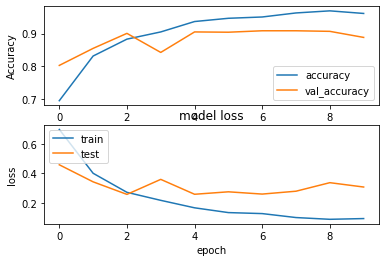

In [21]:
model = model1()

In [22]:
model.save('/content/drive/MyDrive/MajorProject/Models/finalModel.h5')

In [23]:
import tensorflow as tf
new_model = tf.keras.models.load_model('/content/drive/MyDrive/MajorProject/Models/finalModel.h5')
# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                        

In [24]:
y_test_predict = new_model.predict(X_test)
y_pred = []
for y_p in y_test_predict:
  y_pred.append(np.argmax([y_p]))
y_pred = np.array(y_pred).reshape((len(y_pred),1))

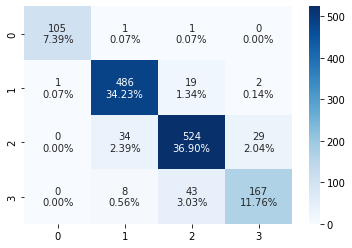

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test , y_pred)


group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v2}\n{v3}" for v2, v3 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(4,4)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [26]:
def prediction(test_filepath,offset=0,duration=1):
  signal, sr = librosa.load(test_filepath,sr=16000,duration=duration,offset=offset) ## offset 
  feature = stft(signal,sr)
  size = feature.shape
  print("size : ",size)
  feature = feature.reshape(1,size[0],size[1])
  output = new_model.predict(feature)
  output = np.argmax(output)
  return output

In [47]:
import matplotlib.pyplot as plot
from scipy.io import wavfile
import numpy as np
import librosa
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

def plotCounts(test_filepath,output):
      samplingFrequency, signalData = wavfile.read(test_filepath)

      plot.figure(figsize=(15,12))
      plot.subplot(211)
      plot.title('Audio Signal')
      duration = len(signalData)/samplingFrequency
      time = np.arange(0,duration,1/samplingFrequency)

      for i in range(0,5):
        if output[i]==0:
          plot.axvspan(i, i+1, color='plum', alpha=0.5, lw=0,label='count=0')
          plot.plot(time[i*samplingFrequency:(i+1)*samplingFrequency],signalData[i*samplingFrequency:(i+1)*samplingFrequency],color='violet')
        elif output[i]==1:
          plot.axvspan(i, i+1, color='turquoise', alpha=0.5, lw=0,label='count=1')
          plot.plot(time[i*samplingFrequency:(i+1)*samplingFrequency],signalData[i*samplingFrequency:(i+1)*samplingFrequency],color='darkturquoise')
        elif output[i]==2:
          plot.axvspan(i, i+1, color='palegreen', alpha=0.5, lw=0,label='count=2')
          plot.plot(time[i*samplingFrequency:(i+1)*samplingFrequency],signalData[i*samplingFrequency:(i+1)*samplingFrequency],color='green')
        else:
          plot.axvspan(i, i+1, color='indianred', alpha=0.5, lw=0,label='count=>2')
          plot.plot(time[i*samplingFrequency:(i+1)*samplingFrequency],signalData[i*samplingFrequency:(i+1)*samplingFrequency],color='red')
        

      Count_0 = mpatches.Patch(color='plum', label='Count=0')
      Count_1 = mpatches.Patch(color='turquoise', label='Count=1')
      Count_2 = mpatches.Patch(color='palegreen', label='Count=2')
      Count_greater_2 = mpatches.Patch(color='indianred', label='Count=>2')
      plt.legend(handles=[Count_0, Count_1,Count_2,Count_greater_2],loc=1,prop={'size': 16})

      plot.xlabel('Time(s)')
      plot.ylabel('Amplitude')
      plt.show()
      #%cd /content/drive/MyDrive/MajorProject
      #plot.savefig('plotCounts')
      #plot.close()

      plot.figure(figsize=(19,13))
      plot.subplot(212)
      plot.specgram(signalData,Fs=samplingFrequency)
      plot.title('Spectrogram')
      plot.colorbar()
      plot.xlabel('Time')
      plot.ylabel('Frequency')
      plt.show()
      #plot.savefig('Spectogram')
      #plot.close()

size :  (129, 63)
size :  (129, 63)
size :  (129, 63)
size :  (129, 63)
size :  (129, 63)


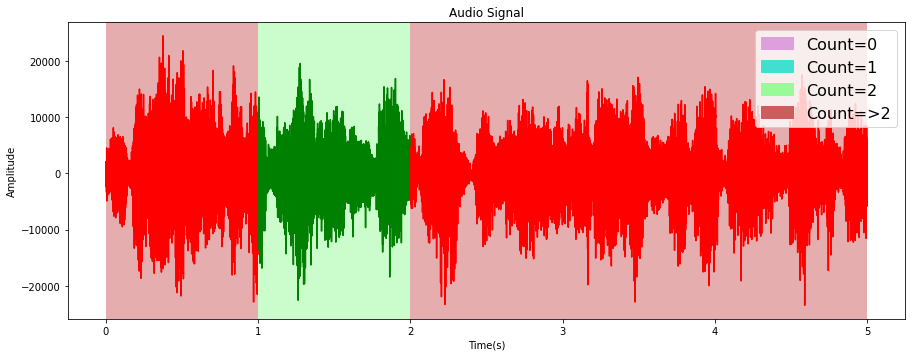

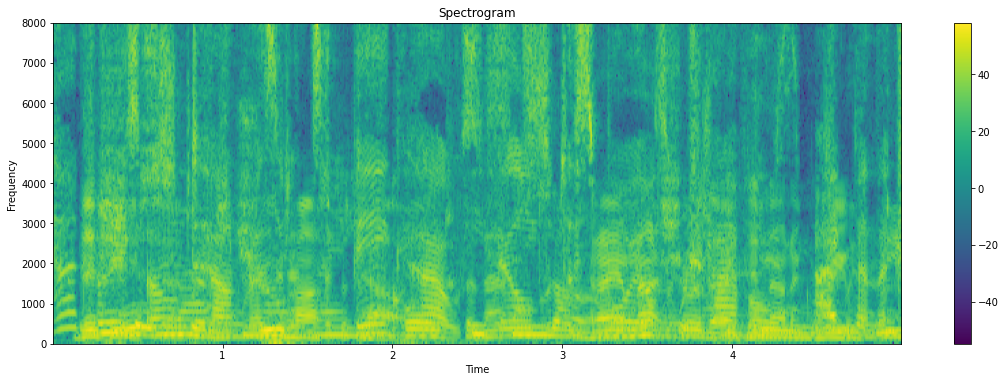

In [68]:
path = '/content/drive/MyDrive/MajorProject/AudioDataset/45_135/'
k1 = 0.5
k2 = 0.2
TwoSource = path+'2_'+str(round(k1,3))+'_'+str(round(k2,3))+'.wav'
SingleSource = path+'1_'+str(round(k1,3))+'_'+str(round(0,3))+'.wav'
#SingleSource='/content/drive/MyDrive/MajorProject/s1_female.wav'
NoSource='/content/drive/MyDrive/MajorProject/AudioDataset/0/0_0216c2.wav'

test_filepath ='/content/drive/MyDrive/MajorProject/s1_female.wav'
test_filepath = '/content/4_0a2d9d.wav'
output = []
for i in range(5):
  output.append(prediction(test_filepath,i,1))
plotCounts(test_filepath,output)

In [66]:
import IPython.display as ipd
ipd.Audio(test_filepath) 

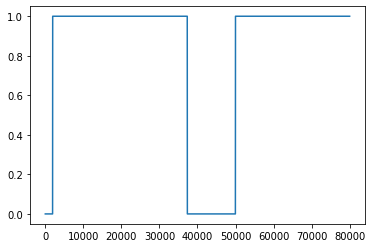

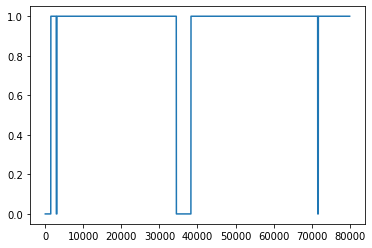

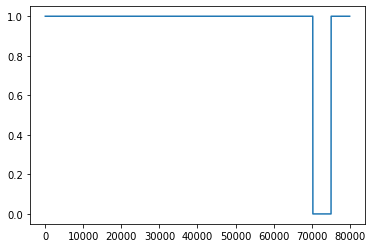

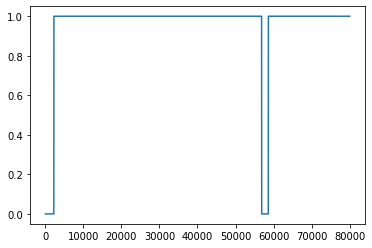

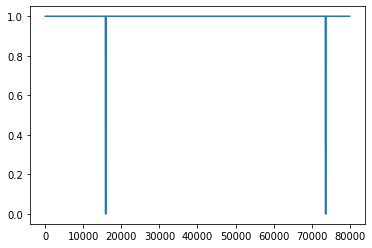

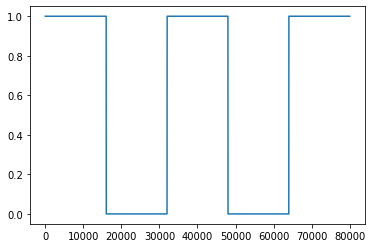

In [67]:
in1 =  [[1917, 37312], [49964, 80000]]
in2 =  [[1436, 2877], [3038, 34429], [38273, 71586], [71746, 80000]]
in3 =  [[0, 70304], [75109, 80000]]
in4 = [[2237, 56851], [58613, 80000]]
in5 = [[0, 15788], [15948, 73605], [73766, 80000]]
in6 = [[0,16000],[16000,32000],[32000,48000],[48000,64000],[64000,80000]]
p1 = [0]*80000
p2 = [0]*80000
p3 = [0]*80000
p4 = [0]*80000
p5 = [0]*80000
p6 = [0]*80000

for r in in1:
  for i in range(r[0],r[1]):
    p1[i]=1

for r in in2:
  for i in range(r[0],r[1]):
    p2[i]=1


for r in in3:
  for i in range(r[0],r[1]):
    p3[i]=1

for r in in4:
  for i in range(r[0],r[1]):
    p4[i]=1

for r in in5:
  for i in range(r[0],r[1]):
    p5[i]=1

c = 1
for r in in6:
  for i in range(r[0],r[1]):
    p6[i]=c
  if(c==1):
    c=0
  else:
    c=1

plt.plot(p1)
plt.show()
plt.plot(p2)
plt.show()
plt.plot(p3)
plt.show()
plt.plot(p4)
plt.show()
plt.plot(p5)
plt.show()
plt.plot(p6)
plt.show()